# I. Condorcet's Jury Theorem (1785)

Condorcet's jury theorem is a political science theorem about the relative probability of a given group of individuals arriving at a correct decision. The assumptions of the theorem are that a group wishes to reach a decision by majority vote.

Assume voter probability to be correct as $p>.5$.

In this part I will:

1. Plot the probability a jury of $n$ voters (odd) is correct as a function of $p$ for different $n$ using Monte-Carlo simulations (sampling and averaging).

2. Show with a plot that as number of jury members grows, $n\rightarrow\infty$ , the jury majority becomes correct $\Pr(\text{correct}) \rightarrow 1$ (with the help of the law of large numbers).


In [ ]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import seaborn as sns
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
# !pip install shap
import shap
from sklearn.model_selection import learning_curve

In [ ]:
def Jury_calculation(n, p):
  yes_votes_per_exp = np.random.binomial(n, p, size=5000)  # Drawn samples from the parameterized binomial distribution, where each sample is equal to the number of successes over the n trials
  return np.mean(yes_votes_per_exp > n / 2)  # Mean of number of voters where the jury are correct (most of the participants said yes)

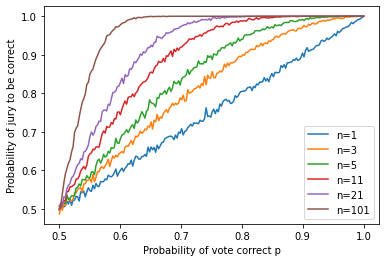

In [ ]:
yes_probas = np.linspace(0.5, 1, 200)  # Experiments on different probabilities to vote yes (success). 0.5 is the lower bound
n_samples = [1, 3, 5, 11, 21, 101]  # Experiments on a different number of samples, i.e. number of participants on each experiment (all are odd numbers)
res = []
for n in n_samples:  # n*p times experimenting
  res.append([Jury_calculation(n, p) for p in yes_probas])

# Plotting the probability a jury of n voters is correct as a function of p for different n using Monte-Carlo simulations
for i, n_sample in enumerate(n_samples):
  plt.plot(yes_probas, res[i], label=f'n={n_sample}')
plt.legend()
plt.xlabel('Probability of vote correct p')
plt.ylabel('Probability of jury to be correct')
plt.show()

Now, let's show that as number of jury members grows, n → ∞ ,the jury majority becomes correct.

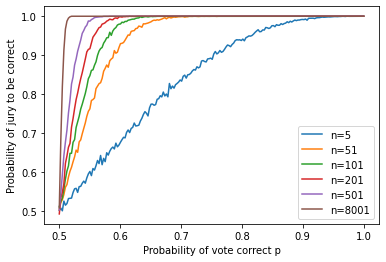

In [ ]:
# Let's see a visual proof of the claim
yes_probas = np.linspace(0.5, 1, 200)  # Experiments on different probabilities to vote yes (success). 0.5 is the lower bound
n_large = [5, 51, 101, 201 ,501, 8001]  # Using the law of large numbers
res = []
for n in n_large:  # n*p times experimenting
  res.append([Jury_calculation(n, p) for p in yes_probas])

# Plotting the probability a jury of n voters is correct as a function of p for different n using Monte-Carlo simulations
for i, n_large_sample in enumerate(n_large):
  plt.plot(yes_probas, res[i], label=f'n={n_large_sample}')
plt.legend()
plt.xlabel('Probability of vote correct p')
plt.ylabel('Probability of jury to be correct')
plt.show()

# II. AdaBoost (35 points)



*   In this part, I will use `AdaBoostClassifier`model from sklearn.ensemble to find a strong classifier on the sample set given below, using $n$ weak learners:
    - For the base weak learners, I will use a ***linear*** SVM classifier ( `LinearSVC` from sklearn.svm) with the next parameters:
        - *tol=1e-5,loss='hinge', C=1e5, max_iter=1e6*
    - Splitting the sample set into 2/3 train set and 1/3 test set.
    - Training ensemble classifiers where each has a different number of estimators $n\in \{1, 3, 10, 50, 100, 1000, 10000\}$.
<br><br/>
* I will answer on the next interesting questions:

 1. How does the overall train set accuracy change with $n$?
 2. Does the model start to overfit at some point? How can we test and detect such a point?
 3. What is the optimal number of estimators For this specific task?


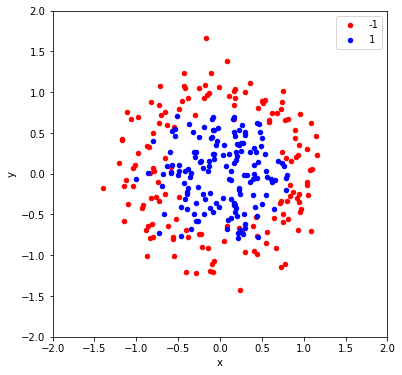

In [ ]:
from sklearn.datasets import make_circles
from matplotlib import pyplot as plt
from pandas import DataFrame

# generate 2d classification dataset
X, y = make_circles(n_samples=300, noise=0.2, random_state=101, factor=0.5)
y = y*2 - 1
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {-1:'red', 1:'blue'}
fig, ax = plt.subplots(figsize=(6,6))
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.show()

In [ ]:
def plot_data(X, y, h, ax):
    '''Plotting function. The function will plot the given instances as well will color the
    background according to the decision boundaries of the model.
    X - 2D array
    y - Vector of labels
    h - A function which accepts X and returns the predicted labels. It should be based on the trained model.
    ax - axes.Axes object as returned by matplotlib.pyplot.subplots function.'''
    def make_meshgrid(x, y, h=.01):
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
        return xx, yy

    def plot_contours(ax, clf, xx, yy, **params):
        Z = h(np.c_[xx.ravel(), yy.ravel()])  # predictions
        Z = Z.reshape(xx.shape)
        if 'levels' in params and len(params['levels'])<2:
          out = ax.contour(xx, yy, Z, **params, colors='k', edgesize=10)
        else:
          out = ax.contourf(xx, yy, Z, **params)
        return out

    # scatter plot, dots colored by class value
    df = DataFrame(dict(x0=X[:,0], x1=X[:,1], label=y))
    colors = {-1:'red', 1:'blue'}
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x0', y='x1',
                 alpha=0.5, label=key, color=colors[key])

    # decision boundary
    xx1, xx2 = make_meshgrid(X[:,0], X[:,1])
    plot_contours(ax, h, xx1, xx2, alpha=0.2)#, levels=[0.5])

    ax.axis('scaled')

For 1 weak learners:
The train accuracy is: 0.525
The mean estimator error is: 0.47500000000000014
The test accuracy is: 0.45
 


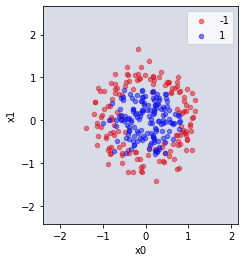

---------------------------------------------------------
For 3 weak learners:
The train accuracy is: 0.57
The mean estimator error is: 0.460197089672499
The test accuracy is: 0.53
 


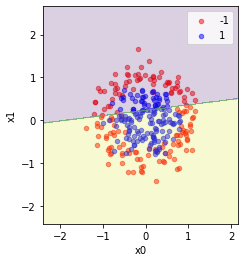

---------------------------------------------------------
For 10 weak learners:
The train accuracy is: 0.65
The mean estimator error is: 0.4530035488273576
The test accuracy is: 0.58
 


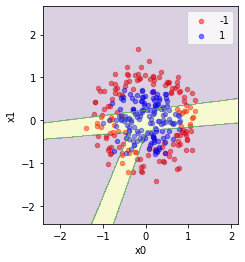

---------------------------------------------------------
For 50 weak learners:
The train accuracy is: 0.675
The mean estimator error is: 0.8694940829038491
The test accuracy is: 0.62
 


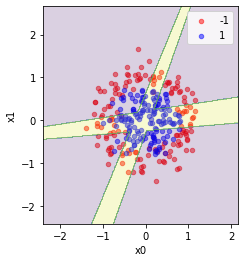

---------------------------------------------------------
For 100 weak learners:
The train accuracy is: 0.675
The mean estimator error is: 0.9347470414519244
The test accuracy is: 0.62
 


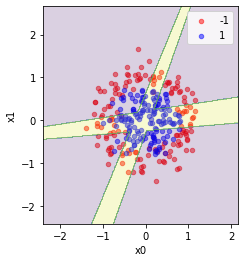

---------------------------------------------------------
For 1000 weak learners:
The train accuracy is: 0.675
The mean estimator error is: 0.9934747041451923
The test accuracy is: 0.62
 


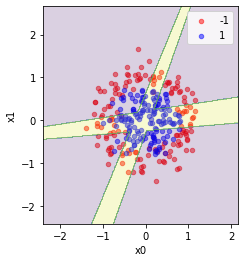

---------------------------------------------------------
For 10000 weak learners:
The train accuracy is: 0.675
The mean estimator error is: 0.9993474704145192
The test accuracy is: 0.62
 


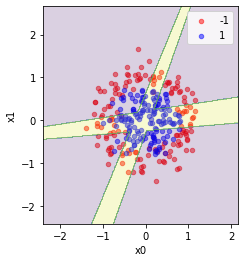

---------------------------------------------------------


In [ ]:
lin_svc = LinearSVC(tol=1e-5,loss='hinge', C=1e5, max_iter=1e6)  # Creates LinearSVC object

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.333, random_state = 42)  # Split the sample set into 2/3 to training set and 1/3 to test set.
n_est_list = [1, 3, 10, 50, 100, 1000, 10000]  # Number of weak learners
train_acc_values = []  # A List contanins all the train accuracy values for each n_est
test_acc_values = []  # A List contanins all the test accuracy values for each n_est
estimator_errors = []  # A List contanins all the estimator errors for each n_est

for est in n_est_list:
  abc = AdaBoostClassifier(n_estimators = est ,algorithm = "SAMME", base_estimator=lin_svc, random_state = 42)
  model = abc.fit(x_train, y_train)  # Fits the Adaboost Classifer
  train_accuracy = metrics.accuracy_score(y_train, model.predict(x_train))  # The train accuracy
  train_acc_values.append(train_accuracy)
  print("For {} weak learners:".format(est))
  print("The train accuracy is:" ,train_accuracy)
  est_error = np.mean(model.estimator_errors_)  # The estimator error
  estimator_errors.append(est_error)
  print("The mean estimator error is:" ,est_error)
  test_accuracy = metrics.accuracy_score(y_test, model.predict(x_test))  #  The test accuracy
  test_acc_values.append(test_accuracy)
  print("The test accuracy is:" ,test_accuracy)
  print(" ")
  _ ,ax = plt.subplots()
  plot_data(X, y, model.predict ,ax)  # plots the final decision plane of each ensemble model
  plt.show()
  print("---------------------------------------------------------")

**1. How does the overall train set accuracy change with n?**

The train accuracy is in the range between 0.525 for 1 estimator and 0.675 for 10,000 estimator. The reason that this is relatively narrow range is that every weak learner is attempting to correct the mistakes made by the previous weak learner. If we will examine the mean estimator error we will see that already in 50 weak learners we are getting relativly high error, and for 100 estimators and above, this is already a value that tends to 1. Estimator error defined as the fraction of the training samples that the weak learner misclassifies, so it can be seen that we have exceeded the amount of estimator we need quite quickly. Therefore, in my opinion it can be said that after 50 it was enough to reach the break-even point.

**2. Does the model start to overfit at some point? How can we test and detect such a point?**

Overfitting can be identified by checking validation metrics such as accuracy and loss. The validation metrics usually increase until a point where they stagnate or start declining when the model is affected by overfitting. During an upward trend, the model seeks a good fit, which, when achieved, causes the trend to start declining or stagnate. As we can see, after the 50th iteration, the accuracy is standing still.

Text(0, 0.5, 'Accuracy')

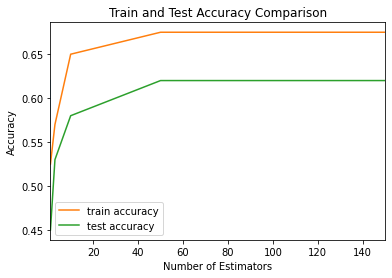

In [ ]:
# Train and Test Accuracy Comparison
plt.plot(train_acc_values, test_acc_values)
plt.plot(n_est_list, train_acc_values, label = "train accuracy")
plt.plot(n_est_list, test_acc_values, label = "test accuracy")
plt.xlim(1, 150)
plt.legend()
plt.title("Train and Test Accuracy Comparison")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")

**3.What is the optimal number of estimators For this specific task?**

In order to find the optimal number of estimators (weak learners), I will use the estimator_errors_ attribute of AdaBoostClassifier. I trained the model with different numbers of weak learners, thus it can be evaluated the model's performance for each iteration. Accordingly, I will choose the number of weak learners that yields the best performance according to the minimum mean error on his predictions. Another way is to perform GridSearchCV and to define the different numbers of weak learners in the param_grid. In that way, I will find the best number of weak learners based on the performance as well.

The optimal number of estimators is: 10 , which yields the minimum error of: 0.4530035488273576
 


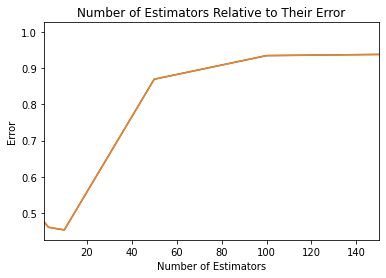

In [ ]:
# Number of Estimators Relative to Their Error
plt.plot(n_est_list, estimator_errors)
plt.plot(n_est_list, estimator_errors)
plt.xlim(1, 150)
plt.title("Number of Estimators Relative to Their Error")
plt.xlabel("Number of Estimators")
plt.ylabel("Error")

min_est_error = min(estimator_errors)
opt_est_idx = estimator_errors.index(min_est_error)
print("The optimal number of estimators is:",n_est_list[opt_est_idx], ", which yields the minimum error of:", min_est_error)
print(" ")

---
# Section 2
---

# miRNA animals interaction prediction





In [ ]:
# Import Kaggle Dataset
from google.colab import files

# upload kaggle.json file using user prompt
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# download the dataset
!kaggle competitions download -c mirna-cross-species-prediction
# extract the files
!unzip '/content/mirna-cross-species-prediction.zip'

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes
 99% 42.0M/42.6M [00:01<00:00, 39.7MB/s]
100% 42.6M/42.6M [00:01<00:00, 24.7MB/s]
Archive:  /content/mirna-cross-species-prediction.zip
  inflating: sub.csv                 
  inflating: x_test.csv              
  inflating: x_train.csv             
  inflating: y_train.csv             


In [ ]:
# Imports data from kaggle
x_test = pd.read_csv('/content/x_test.csv')
x_train = pd.read_csv('/content/x_train.csv')
y_train = pd.read_csv('/content/y_train.csv')
sub = pd.read_csv('/content/sub.csv')

### EDA - Exploratory Data Analysis
In this part, I will use visual tools to present and explain the data, which will include statistics, images, and conclusions.


In [ ]:
# Cleaning the train data
x_train = x_train.drop(columns=['id'], axis=1)  # Removes the 'id' column
y_train = y_train.drop(columns=['id'], axis=1)  # Removes the 'id' column
X_train_unlab = x_train[y_train.label.isna()]  # All the records in x_train that are without labels
X_train_lab = x_train[np.invert(y_train.label.isna())]  # All the records is x_train that are *with* labels
y_train_without_nulls = y_train.dropna()
full_train_with_labels = pd.concat([X_train_lab, y_train_without_nulls], axis=1)  # The complete data (X's and their labels)

In [ ]:
# Cleaning the test data
id_attribute = x_test['id']  # Saving the id column, in order to present it in the final submission
x_test = x_test.drop(columns=['id'], axis=1)

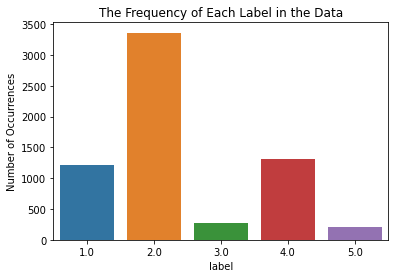

In [ ]:
# 1st plot: The Frequency of Each Label in the Data
ax = sns.barplot( x=full_train_with_labels['label'].value_counts().index, y=full_train_with_labels['label'].value_counts())
ax.set(xlabel='label', ylabel='Number of Occurrences')
plt.title("The Frequency of Each Label in the Data")
plt.show()

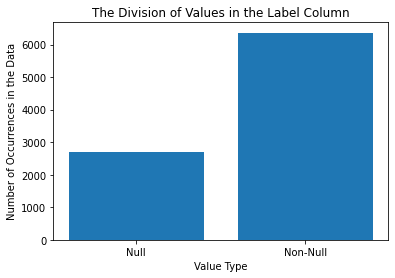

In [ ]:
null_count = y_train['label'].isna().sum()  # Counts number of null values in the label column
non_null_count = y_train.shape[0] - null_count  # Counts number of non-null values in the label column

# 2nd plot: The Division of Values in the Label Column
plt.bar(['Null', 'Non-Null'], [null_count, non_null_count])
plt.xlabel("Value Type")
plt.ylabel("Number of Occurrences in the Data")
plt.title("The Division of Values in the Label Column")
plt.show()

The column with the most null values in our dataset is: Acc_P12_5th



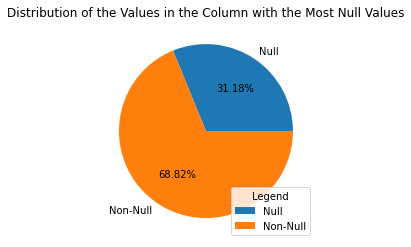

In [ ]:
# Counts the number of null values in each column
null_counts = full_train_with_labels.isna().sum()
max_null_col = null_counts.idxmax()  # Finds the column with the maximum number of null values

# 3rd plot: Distribution of the Values in the Column with the Most Null Values
plt.pie([x_train['Acc_P12_5th'].isna().sum(),(x_train.shape[0] - x_train['Acc_P12_5th'].isna().sum())],labels= ['Null', 'Non-Null'],autopct=lambda p: '{:.2f}%'.format(p))
plt.legend(title='Legend', fontsize=10, loc='lower right')
plt.title('Distribution of the Values in the Column with the Most Null Values')
print("The column with the most null values in our dataset is:" ,max_null_col)
print("")

As we can see, I dived into the data, analyzed and explored it for the first time to get an initial picture of the miRNA animals data set. The goal of this step is to get a real understanding of the distribution of the data, its values, and to act accordingly later on. The data analysis will help later in the pre-processing phase. I presented 3 plots showing statistical analyzes of the data, summary graphs, from which important conclusions can be drawn:

1. The first plot presents the frequency of each label in the trainning set. I performed value count for each label in the label column (excluding null values). This bar plot gives a picture of the distribution of the label values.
2. The second plot presents the division of values in the label column. I counted the number of null and non-null values in the label column. This bar plot helps to know how many records in the training set are unlabeled.
3. The third plot presents the distribution of the values in the column with the most null values. I found the column with the maximum number of null values and displayed their relative share in the column. This pie plot helps to know which is the "most problematic" column in terms of missing values. I.e., it will have to be filled with the most artificial values in the pre-processing stage and it will probably also be the least accurate.

### Preprocessing


In [ ]:
# Creates a list of the columns containing numeric values
numeric_cols = full_train_with_labels.select_dtypes(include=np.number).columns.tolist()
numeric_cols_without_label = numeric_cols[:-1]  # Removes the label column

In [ ]:
# Performs standartization on the x_train numeric values
scaler = StandardScaler()
numeric_cols_df = pd.DataFrame(scaler.fit_transform(full_train_with_labels[numeric_cols_without_label]), columns=numeric_cols_without_label)

In [ ]:
# Performs standartization on the x_test numeric values
new_scaler = StandardScaler()
numeric_cols_xtest_df = pd.DataFrame(new_scaler.fit_transform(x_test[numeric_cols_without_label]), columns=numeric_cols_without_label)

In [ ]:
# Creates a data frame of the columns contaning only x_train categorical values
categorical_cols = full_train_with_labels.select_dtypes(include=object).columns
categorical_cols_df = full_train_with_labels[categorical_cols]

In [ ]:
# Creates a data frame of the columns contaning only x_test categorical values
categorical_cols_xtest_df = x_test[categorical_cols]

In [ ]:
# The df after converting categorical variable into dummy/indicator variables in x_train
dummy_df = pd.get_dummies(categorical_cols_df, dummy_na=False)

In [ ]:
# The df after converting categorical variable into dummy/indicator variables in x_test
dummy_xtest_df = pd.get_dummies(categorical_cols_xtest_df, dummy_na=False)

In [ ]:
# fills the missing values (NaN) with the mean value of each column in x_train
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')  # Creates a simple imputer object
imputer = imputer.fit(numeric_cols_df)
imp_numeric_cols_df = imputer.transform(numeric_cols_df)
numeric_cols_df = pd.DataFrame(imp_numeric_cols_df,columns = numeric_cols_df.columns)  # the updated data without missing values

In [ ]:
# fills the missing values (NaN) with the mean value of each column in x_test
new_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')  # Creates a simple imputer object
new_imputer = new_imputer.fit(numeric_cols_xtest_df)
imp_numeric_cols_x_test_df = new_imputer.transform(numeric_cols_xtest_df)
numeric_cols_xtest_df = pd.DataFrame(imp_numeric_cols_x_test_df,columns = numeric_cols_df.columns)  # the updated data without missing values

In [ ]:
# Merge the numeric dataframe with the dummy variables table in order to create the 'All numeric' complete dataframe for the train
complete_df = pd.concat([numeric_cols_df.reset_index(), dummy_df.reset_index()],axis=1)
complete_df = complete_df.drop(columns=['index'], axis=1)  # Removes the 'id' column
complete_df['label'] = y_train_without_nulls['label'].tolist()  # Adds the labels (without the missing ones)

In [ ]:
# Merge the numeric dataframe with the dummy variables table in order to create the 'All numeric' complete dataframe for the test (without labels)
complete_xtest_df = pd.concat([numeric_cols_xtest_df.reset_index(), dummy_xtest_df.reset_index()],axis=1)
complete_xtest_df = complete_xtest_df.drop(columns=['index'], axis=1)  # Removes the 'id' column

In this part, I performed the preprocessing phase. The purpose is to transform the data to a way it can fit into the model in the 'Model Training' phase. All the operations was made both on the train data and on the x_test data. First, I created a list of the columns containing numeric values. Then, performed standartization on the X numeric values. Secondly, I created a data frame of the columns contaning only the X categorical values. Then, I decided to convert them into dummy/indicator variables in order to represent them in numeric type. Third, I filled the missing values (NaN) with the mean value of each column via Imputer object. In conclusion, I merge the numeric dataframe with the dummy variables table in order to create the 'All numeric' complete dataframe.


### Model training:
In this part, I will train a XGBoost classifier.



In [ ]:
# Spliting the fixed data (after preprocessing) into X,Y
x_fixed_train = complete_df.iloc[:,:-1]
y_fixed_train = complete_df['label']

In [ ]:
# Spliting the training data into two sets: practice and validation. 75% for practice and 25% for validation
x_to_practice, x_to_validate, y_to_practice, y_to_validate = train_test_split(x_fixed_train, y_fixed_train, test_size=0.25, random_state=123)

In [ ]:
# Set up the parameters for the grid search
parameters = {'max_depth': [3, 5, 7],
              'learning_rate': [0.1, 0.3, 0.5],
              'n_estimators': [25, 40, 70, 100],
              }

In [ ]:
# Creates XGB calssifier object
xgbc = XGBClassifier()

In [ ]:
# Use GridSearchCV to find the best combination of hyperparameters
grid_search1 = GridSearchCV(xgbc, parameters, cv=5, scoring='accuracy')
grid_search1.fit(x_to_practice, y_to_practice)
print(grid_search1.best_params_)
predictions = grid_search1.best_estimator_.predict(complete_xtest_df)

{'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100}


In [ ]:
fitted_model = xgbc.fit(x_to_practice,y_to_practice)
preds_of_validation = fitted_model.predict(x_to_validate)

In [ ]:
preds_to_submission = xgbc.predict(complete_xtest_df)
int_list = [int(x) for x in preds_to_submission]

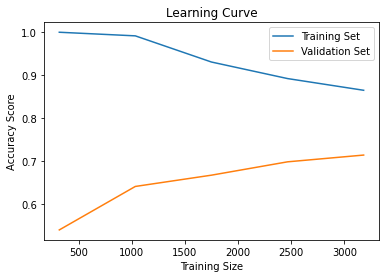

In [ ]:
# plots the learning curve based on Accuracy score
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(xgbc, x_to_practice, y_to_practice, cv=3,scoring='accuracy', return_times=True)
plt.plot(train_sizes,np.mean(train_scores,axis=1), label="Training Set")
plt.plot(train_sizes,np.mean(test_scores,axis=1), label="Validation Set")
plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")

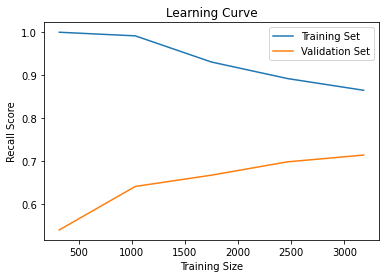

In [ ]:
# plots the learning curve based on micro recall score
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(xgbc , x_to_practice , y_to_practice , cv=3 ,scoring='recall_micro', return_times=True)
plt.plot(train_sizes,np.mean(train_scores,axis=1), label="Training Set")
plt.plot(train_sizes,np.mean(test_scores,axis=1), label="Validation Set")
plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Recall Score")
plt.legend(loc="best")

The more we train on the training set, the model that will be built will be a more general model and less adapted to the first examples it has seen. As a result, its Accuracy value will decrease from 1 until it hopefully balances out at a certain relatively high value. At the same time, if the model is a good model, the accuracy of the validation set will improve as the model is more generalized. It can be seen in the graph that as you increase the test set the quality really increases and this is reflected in the increase in the accuracy values. The results are statistically significant compared to the distribution of the data.

Similarly, the recall graph shows the same behavior because the more we increase the test set, the more justified we are in terms of classification. The TP will increase significantly compared to the FP.



In [ ]:
# Creates the final dataframe of the submission format {id: id's, label: pred labels}
final_pred = pd.DataFrame(id_attribute)
final_pred['label'] = int_list

In [ ]:
# Export csv file of the predictions
final_pred.to_csv("submission.csv", index=False)

First, in order to check the quality of the model, I took the training records that have a label, and split it into two sets: practice and validation. 75% for practice and 25% for validation. using this 25%, I evaluated the model performence in the next section. Before that, I started using these sets to perform hyper parameters tuning to try to understand whether certain parameters improve the model's accuracy values. After tuning, I took the best parameters, and trained the model with them on all the data. Finally, I preformed a predication on the x_test set.

### Model evaluation:
Evaluating the model using different evaluation metrics.



In [ ]:
print("---------------------Model Evaluation--------------------")
print("")
print("Our Accuracy score is: " ,accuracy_score(y_to_validate, preds_of_validation))
print("---------------------------------------------------------")
print("Our Balanced Accuracy score is: " ,balanced_accuracy_score(y_to_validate, preds_of_validation))
print("---------------------------------------------------------")
print("Our Micro Precision score is: " ,precision_score(y_to_validate, preds_of_validation, average='micro'))
print("---------------------------------------------------------")
print("Our Micro Recall score is: " ,recall_score(y_to_validate, preds_of_validation, average='micro'))
print("---------------------------------------------------------")
print("Our Micro F1 score is: " ,f1_score(y_to_validate, preds_of_validation, average='micro'))
print("---------------------------------------------------------")
print("Our Macro Precision score is: " ,precision_score(y_to_validate, preds_of_validation, average='macro'))
print("---------------------------------------------------------")
print("Our Macro Recall score is: " ,recall_score(y_to_validate, preds_of_validation, average='macro'))
print("---------------------------------------------------------")
print("Our Macro F1 score is: " ,f1_score(y_to_validate, preds_of_validation, average='macro'))
print("---------------------------------------------------------")
print("Our Weighted Precision score is: " ,precision_score(y_to_validate, preds_of_validation, average='weighted'))
print("---------------------------------------------------------")
print("Our Weighted Recall score is: " ,recall_score(y_to_validate, preds_of_validation, average='weighted'))
print("---------------------------------------------------------")
print("Our Weighted F1 score is: " ,f1_score(y_to_validate, preds_of_validation, average='weighted'))

---------------------Model Evaluation--------------------

Our Accuracy score is:  0.7523570081709616
---------------------------------------------------------
Our Balanced Accuracy score is:  0.552572687583835
---------------------------------------------------------
Our Micro Precision score is:  0.7523570081709616
---------------------------------------------------------
Our Micro Recall score is:  0.7523570081709616
---------------------------------------------------------
Our Micro F1 score is:  0.7523570081709616
---------------------------------------------------------
Our Macro Precision score is:  0.8528811690102014
---------------------------------------------------------
Our Macro Recall score is:  0.552572687583835
---------------------------------------------------------
Our Macro F1 score is:  0.6203679065576452
---------------------------------------------------------
Our Weighted Precision score is:  0.7645985907426268
---------------------------------------------------

1. **Accuracy and Balanaced Accuracy** - low balanced accuracy in relation to higher accuracy score can indicate that the model is performing much better on some classes than others. This could be due to a variety of factors that needed to digged more deeply to understand about almost 600 atributes.

2. **Micro Precision, Micro Recall and Micro F1**- the 75% score is good. Suppose the model were to classify each record only into the most common class in the data (naive model), we would get score in the area of 53 percent (as the percentage of records in the training data from class 2), but 75 percent is significantly higher and this indicates that the model classifies records relatively well.

3. **Macro Precision** - the score of the macro precision is very abnormal relative to the data given to us considering that the macro methods do not take into account that the data is not balanced. It is likely that this happened purely from a specific division of the data that caused an unreflective result.

4. **Macro Recall** - shows a very reasonable score in that it does not take into account the imbalance of the data and that the most common class is about 53 percent of the data.

5. **Macro F1** -  it is the average of macro precision and macro recall.

6. **Weighted precision, weighted recall and weighted F1** - the 75% score is good. Suppose the model were to classify each record only into the most common class in the data (naive model), we would get score in the area of 53 percent (as the percentage of records in the training data from class 2), but 75 percent is significantly higher and this indicates that the model classifies records relatively well.
<br><br/>

---------------------------------------------------------------------------
---------------------------------------------------------------------------

1.  Accuracy Score: The fraction of correctly classified samples returned by the model. The regular accuracy score is not suitable because it does not take into account the fact that the classes are not balanced and therefore, it is less suitable for this current task.

2. Balanced Accuracy: The balanced accuracy in classification problems is a score that can deal with imbalanced datasets. It is defined as the average of recall obtained on each class. The best value is 1 and the worst value is 0. This score can fit the model very well since it can deal with imbalanced datasets. The data is imbalanced, as I found out in the EDA phase (label 2 appears most significantly in the training set compared to labels 3 and 5 which hardly appear at all). Interpret how accurate the model is as a predictive model. Therefore, this score will help to interpret how accurate the model is in a better way.

3. Micro Precision: The precision is the ratio tp / (tp + fp). The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. The micro calculates metrics globally by counting the total true positives, false negatives and false positives. This score can fit the data well since it often used in situations where the classes are imbalanced (like in this case) and it is important to consider the overall performance of the model across all classes, rather than just focusing on the performance for individual classes.

4. Micro Recall: The recall is the ratio tp / (tp + fn). The recall is intuitively the ability of the classifier to find all the positive samples. The micro calculates metrics globally by counting the total true positives, false negatives and false positives. This score can fit the data well since it often used in situations where the classes are imbalanced, and it is important to consider the overall performance of the model across all classes, rather than just focusing on the performance for individual classes.

5. Micro F1-score: The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is: F1 = 2 * (precision * recall) / (precision + recall) In the multi-class and multi-label case, this is the average of the F1 score of each class with weighting depending on the average parameter. The micro calculates metrics globally by counting the total true positives, false negatives and false positives. This score can fit the data well since it also often used in situations where the classes are imbalanced.

6. Macro Precision: The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.Macro calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account. This does not fit the current data because the taining data is imbalance as observed in the plot.

7. Macro Recall: The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples. Macro calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account. This metric doest not fit the current data.

8. Macro F1-score: The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. Macro calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account. This metric doest not fit the current data.

9. Weighted Precision: The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. This alters 'macro' to account for label imbalance. It is useful in situations where the classes are imbalanced, as it gives more weight to the precision of the underrepresented classes like in the currrent case.

10. Weighted Recall: The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.This alters 'macro' to account for label imbalance. It is useful in situations where the classes are imbalanced, as it gives more weight to the precision of the underrepresented classes like in the currrent case.

11. Weighted F1-score: The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. This alters 'macro' to account for label imbalance (which fit to the data), but it can result in an F-score that is not between precision and recall, so I will prefer not to use it in this case.

### Explainability:
In this part, I will explain the results of the model using SHAP, and attach relevant outputs.

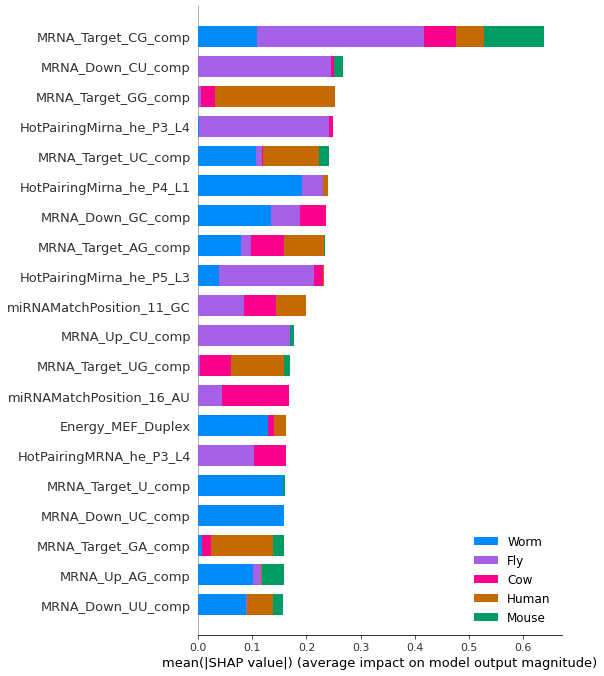

In [ ]:
# The real labels (the animals)
classes = ['Fly', 'Cow', 'Human', 'Mouse','Worm']
explainer = shap.TreeExplainer(xgbc,feature_perturbation = "interventional", model_output="raw")
shap_values = explainer.shap_values(x_to_validate)
shap.summary_plot(shap_values, x_to_validate, class_names= classes)

Findings:


*   It can be seen that according to the variables shown, the classes most affected by these features were 'Worm' and 'Fly'.

* 'MRNA_target_U_comp' and 'MRNA_target_UC_comp' are probably features who relate only to the RNA of a worm, and this is the reason they are only influencing it.

* 'Hot_pairingmirna_he_p3_l4', 'MRNA_down_CU_comp' and 'MRNA_down_CU_comp' are attribute only to fly RNA, and this is the reason they are only influencing it.

* Another thing that can be seen in the graph is that it is divided into 3 trends in terms of influence, the lower half similarly affects absolute value of the measure, the upper half influences in a slightly stronger way and there is one feature that has an abnormal influence compared to the others.

*   Another thing that can be concluded from the shap graph is that there is almost no effect on the mouse population. It can be assumed that this probably happens because of little information about mice in the data.




